<a href="https://colab.research.google.com/github/JohnFBraman/AI-Crash-Course/blob/master/latlonelev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

File 'USGS_1M_11_x47y367_San_Diego_CA_2014_LiDAR.tif' already exists. Skipping download.
CRS: EPSG:26911
Original lat_coords (first, last): (33.0781260006824, 33.168666033305556)
Reversed lat_coords (first, last): (33.168666033305556, 33.0781260006824)
Minimum elevation: 0.7747353911399841 meters
Maximum elevation: 317.9566650390625 meters
Mean elevation: 84.84050898831829 meters


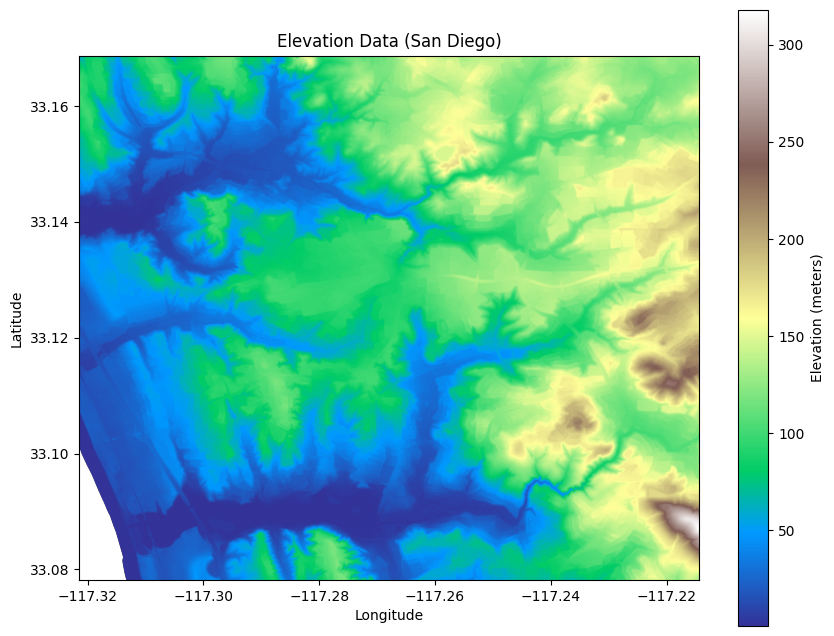

In [2]:
#!pip install rasterio

#!pip install rasterio pyproj

import requests
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os
import urllib.parse
from pyproj import Transformer


# URL of the elevation data Source:
# https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1m/Projects/San_Diego_CA_2014_LiDAR/TIFF/USGS_1M_11_x47y366_San_Diego_CA_2014_LiDAR.tif
# https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1m/Projects/San_Diego_CA_2014_LiDAR/TIFF/USGS_1M_11_x47y367_San_Diego_CA_2014_LiDAR.tif

url = "https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1m/Projects/San_Diego_CA_2014_LiDAR/TIFF/USGS_1M_11_x47y367_San_Diego_CA_2014_LiDAR.tif"

try:
    # Extract filename from URL
    parsed_url = urllib.parse.urlparse(url)
    filename = os.path.basename(parsed_url.path)

    if not filename:
        filename = "elevation_data.tif"
        print("Warning: Could not extract filename from URL. Using default filename: elevation_data.tif")

    # Check if file exists; download only if needed.
    if os.path.exists(filename):
        print(f"File '{filename}' already exists. Skipping download.")
    else:
        response = requests.get(url, stream=True)
        response.raise_for_status()

        with open(filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)

        print(f"File '{filename}' downloaded successfully.")

    with rasterio.open(filename) as src:
        elevation_data = src.read(1)
        transform = src.transform
        bounds = src.bounds
        src_crs = src.crs
        print(f"CRS: {src.crs}") # Print CRS

        nodata_value = src.nodata # Get the nodata value

        #Handle nodata value
        if nodata_value is not None:
          elevation_data = np.ma.masked_equal(elevation_data, nodata_value)
#flip Y axis
        elevation_data = np.flipud(elevation_data)  # Flip the array vertically

        # Define the target CRS (WGS 84)
        target_crs = "EPSG:4326"

        # Create a transformer object
        transformer = Transformer.from_crs(src_crs, target_crs, always_xy=True)

        # Reproject the bounds to lat/lon
        xmin, ymin = transformer.transform(bounds.left, bounds.bottom)
        xmax, ymax = transformer.transform(bounds.right, bounds.top)

        # Create the plot (using lat/lon)
        rows, cols = elevation_data.shape
        lon_coords = np.linspace(xmin, xmax, cols)
        lat_coords = np.linspace(ymin, ymax, rows)

        print(f"Original lat_coords (first, last): ({lat_coords[0]}, {lat_coords[-1]})") # Data check
        print(f"Reversed lat_coords (first, last): ({lat_coords[::-1][0]}, {lat_coords[::-1][-1]})") # Data check

        lon, lat = np.meshgrid(lon_coords, lat_coords)

        #lon, lat = np.meshgrid(lon_coords, lat_coords[::-1]) #<-- This line is changed

        plt.figure(figsize=(10, 8))

        plt.imshow(elevation_data, extent=[xmin, xmax, ymin, ymax], cmap='terrain', origin='lower')

        plt.colorbar(label='Elevation (meters)')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title('Elevation Data (San Diego)')


        #plt.imshow(elevation_data, extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
        #          cmap='terrain', origin='lower')
        #plt.colorbar(label='Elevation (meters)')
        #plt.xlabel('Easting (meters)')  # Changed to Easting
        #plt.ylabel('Northing (meters)') # Changed to Northing
        #plt.title('Elevation Data (San Diego)')
        #plt.show()

        #Print stats after masking
        print(f"Minimum elevation: {np.min(elevation_data)} meters")
        print(f"Maximum elevation: {np.max(elevation_data)} meters")
        print(f"Mean elevation: {np.mean(elevation_data)} meters")

except requests.exceptions.RequestException as e:
    print(f"Error downloading file: {e}")
except rasterio.errors.RasterioIOError as e:
    print(f"Error opening or reading the elevation data: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")